In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset",help="path to input dataset")
ap.add_argument("-p", "--plot", type=str, default="plot.png",
	help="path to output loss/accuracy plot")
ap.add_argument("-m", "--model", type=str,
	default="mask_detector.model",
	help="path to output face mask detector model")
args = vars(ap.parse_args(args=[]))

In [3]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [4]:
imagePaths = list(paths.list_images(r"C:\Users\Himanshu\Desktop\docs\Computer vision project\face-mask-detector\Practice\dataset"))

In [5]:
data = []
labels = []

In [6]:
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

In [7]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [8]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [9]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [10]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [11]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


C:\Users\Himanshu\Anaconda3\envs\tensorflow\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [12]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [13]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [14]:
for layer in baseModel.layers:
	layer.trainable = False

In [15]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [16]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
34/34 [==============================] - 120s 4s/step - loss: 0.6112 - acc: 0.6770 - val_loss: 0.3897 - val_acc: 0.8478
Epoch 2/20
34/34 [==============================] - 117s 3s/step - loss: 0.3715 - acc: 0.8380 - val_loss: 0.2341 - val_acc: 0.9348
Epoch 3/20
34/34 [==============================] - 125s 4s/step - loss: 0.2992 - acc: 0.8839 - val_loss: 0.1649 - val_acc: 0.9710
Epoch 4/20
34/34 [==============================] - 118s 3s/step - loss: 0.2165 - acc: 0.9242 - val_loss: 0.1290 - val_acc: 0.9710
Epoch 5/20
34/34 [==============================] - 120s 4s/step - loss: 0.2183 - acc: 0.9110 - val_loss: 0.1080 - val_acc: 0.9710
Epoch 6/20
34/34 [==============================] - 117s 3s/step - loss: 0.1770 - acc: 0.9363 - val_loss: 0.0950 - val_acc: 0.9783
Epoch 7/20
34/34 [==============================] - 119s 3s/step - loss: 0.1584 - acc: 0.9391 - 

34/34 [==============================] - 118s 3s/step - loss: 0.0944 - acc: 0.9660 - val_loss: 0.0749 - val_acc: 0.9783
Epoch 17/20
34/34 [==============================] - 119s 4s/step - loss: 0.0835 - acc: 0.9738 - val_loss: 0.0537 - val_acc: 0.9783
Epoch 18/20
34/34 [==============================] - 117s 3s/step - loss: 0.0824 - acc: 0.9714 - val_loss: 0.0941 - val_acc: 0.9710
Epoch 19/20
34/34 [==============================] - 118s 3s/step - loss: 0.0828 - acc: 0.9644 - val_loss: 0.0596 - val_acc: 0.9746
Epoch 20/20
34/34 [==============================] - 119s 4s/step - loss: 0.0833 - acc: 0.9663 - val_loss: 0.0643 - val_acc: 0.9783


In [17]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [18]:
predIdxs = np.argmax(predIdxs, axis=1)

In [19]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.96      1.00      0.98       138
without_mask       1.00      0.96      0.98       138

    accuracy                           0.98       276
   macro avg       0.98      0.98      0.98       276
weighted avg       0.98      0.98      0.98       276



In [20]:
print("[INFO] saving mask detector model...")
model.save(args["model"], save_format="h5")

[INFO] saving mask detector model...


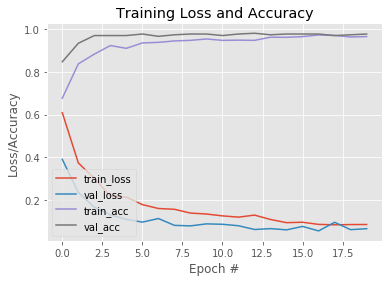

In [22]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])